# QEvasion – Transformer Fine-tuning with Hyperparameter Tuning

This notebook fine-tunes transformer models on the QEvasion dataset with support for:
- **Task 1**: Clarity-level classification (3-way)
- **Task 2**: Evasion-level classification (9-way)
- **Hyperparameter tuning** for learning rate and weight decay

## 1. Environment Setup

In [1]:
# If running on Google Colab, run this cell
!rm -rf political-evasion-classifier
!git clone https://github.com/minh-de-rien/political-evasion-classifier.git
%cd political-evasion-classifier

import sys
sys.path.insert(0, "/content/political-evasion-classifier")

Cloning into 'political-evasion-classifier'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 143 (delta 60), reused 103 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (143/143), 5.11 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (60/60), done.
/content/political-evasion-classifier


In [2]:
# If running locally, run this cell instead
import os
import sys
from pathlib import Path

# Add project root to path
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

In [3]:
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

from src.data import (
    load_qevasion_prepared,
    prepare_task1_data,
    prepare_task2_data,
    map_evasion_to_clarity,
    map_evasion_ids_to_clarity_ids,
    CLARITY_LABELS,
    EVASION_LABELS,
    CLARITY_TO_ID,
    EVASION_TO_ID,
    ID_TO_CLARITY,
    ID_TO_EVASION
)

from src.metrics import (
    evaluate_task1,
    evaluate_task2_standard,
    evaluate_task2_multi_annotator,
    plot_confusion_matrix,
    compute_per_class_metrics,
    majority_baseline_accuracy
)

from src.models import (
    MultiTaskTransformer,
    FocalLoss
)

from src.training import (
    EarlyStopping,
    evaluate,
    evaluate_multitask,
    train_model
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [4]:
from datetime import datetime

def banner(title: str, char: str="=", width: int=88):
    line = char * width
    print("\n" + line)
    print(title.center(width))
    print(line + "\n")

def section(title: str, char: str="-", width: int=88):
    line = char * width
    print("\n" + line)
    print(title)
    print(line + "\n")

def metric_block(title: str, metrics: dict, keys: list, digits: int=4):
    print(f"{title}")
    for k in keys:
        if k in metrics and metrics[k] is not None:
            v = metrics[k]
            if isinstance(v, float):
                print(f"  - {k:30s}: {v:.{digits}f}")
            else:
                print(f"  - {k:30s}: {v}")
    print()

## 2. Configuration

In [5]:
# Models to test
MODELS_TO_TEST = [
    "distilbert-base-uncased",
    "bert-base-uncased",
    "albert-base-v2",
]

# Default hyperparameters (can be overridden per-run)
MAX_LENGTH = 256
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
NUM_EPOCHS = 5
PATIENCE = 3

# Scheduler settings
USE_SCHEDULER = True
WARMUP_RATIO = 0.10

# Random seed & validation size
RANDOM_STATE = 42
VAL_SIZE = 0.1

print("Configuration:")
print(f"  Models: {MODELS_TO_TEST}")
print(f"  Max Length: {MAX_LENGTH}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Default Learning Rate: {LEARNING_RATE}")
print(f"  Default Weight Decay: {WEIGHT_DECAY}")
print(f"  Scheduler: {USE_SCHEDULER} (warmup ratio={WARMUP_RATIO})")
print(f"  Max Epochs: {NUM_EPOCHS}")
print(f"  Patience: {PATIENCE}")
print(f"  Val Size: {VAL_SIZE}")
print(f"  Seed: {RANDOM_STATE}")

Configuration:
  Models: ['distilbert-base-uncased', 'bert-base-uncased', 'albert-base-v2']
  Max Length: 256
  Batch Size: 16
  Default Learning Rate: 2e-05
  Default Weight Decay: 0.01
  Scheduler: True (warmup ratio=0.1)
  Max Epochs: 5
  Patience: 3
  Val Size: 0.1
  Seed: 42


## 3. Load & Explore Data

In [6]:
dataset = load_qevasion_prepared()

# Prepare Task 1 (Clarity)
clarity_train_df, clarity_val_df, clarity_test_df = prepare_task1_data(
    dataset, val_size=VAL_SIZE, random_state=RANDOM_STATE
)

# Prepare Task 2 (Evasion)
evasion_train_df, evasion_val_df, evasion_test_df = prepare_task2_data(
    dataset, val_size=VAL_SIZE, random_state=RANDOM_STATE
)

print("="*60)
print("TASK 1: CLARITY CLASSIFICATION")
print("="*60)
print(f"Train: {len(clarity_train_df)} examples")
print(f"Val:   {len(clarity_val_df)} examples")
print(f"Test:  {len(clarity_test_df)} examples")
print(f"\nLabels: {CLARITY_LABELS}")
print(f"Majority Baseline Accuracy: {majority_baseline_accuracy(clarity_train_df['clarity_id'].values, clarity_test_df['clarity_id'].values):.4f}")

print("\n" + "="*60)
print("TASK 2: EVASION CLASSIFICATION")
print("="*60)
print(f"Train: {len(evasion_train_df)} examples")
print(f"Val:   {len(evasion_val_df)} examples")
print(f"Test:  {len(evasion_test_df)} examples (multi-annotator)")
print(f"\nLabels: {EVASION_LABELS}")
print(f"Majority Baseline Accuracy: {majority_baseline_accuracy(evasion_train_df['evasion_id'].values, evasion_val_df['evasion_id'].values):.4f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/308 [00:00<?, ? examples/s]

TASK 1: CLARITY CLASSIFICATION
Train: 3103 examples
Val:   345 examples
Test:  308 examples

Labels: ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
Majority Baseline Accuracy: 0.6688

TASK 2: EVASION CLASSIFICATION
Train: 3103 examples
Val:   345 examples
Test:  308 examples (multi-annotator)

Labels: ['Claims ignorance', 'Clarification', 'Declining to answer', 'Deflection', 'Dodging', 'Explicit', 'General', 'Implicit', 'Partial/half-answer']
Majority Baseline Accuracy: 0.3043


## 4. Dataset & DataLoader Setup

In [7]:
class QEvasionDataset(Dataset):
    """PyTorch Dataset for QEvasion tasks."""

    def __init__(self, df, tokenizer, max_length, task='clarity'):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.task = task

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['text']

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

        if self.task == 'clarity':
            item['labels'] = torch.tensor(row['clarity_id'], dtype=torch.long)
        elif self.task == 'evasion':
            item['labels'] = torch.tensor(row['evasion_id'], dtype=torch.long)
        elif self.task == 'evasion_test':
            # For test set, no labels needed for prediction
            pass
        elif self.task == 'multitask':
            item['clarity_labels'] = torch.tensor(row['clarity_id'], dtype=torch.long)
            if "evasion_id" in self.df.columns and int(row["evasion_id"]) != -1:
                item["evasion_labels"] = torch.tensor(int(row["evasion_id"]), dtype=torch.long)
                item["evasion_mask"] = torch.tensor(True, dtype=torch.bool)
            else:
                item["evasion_labels"] = torch.tensor(-1, dtype=torch.long)
                item["evasion_mask"] = torch.tensor(False, dtype=torch.bool)

        return item

In [8]:
def cleanup(*objs):
    for o in objs:
        try:
            del o
        except:
            pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [9]:
def build_dataloaders(tokenizer):
    # Task 1: Clarity
    clarity_train_dataset = QEvasionDataset(clarity_train_df, tokenizer, MAX_LENGTH, task="clarity")
    clarity_val_dataset   = QEvasionDataset(clarity_val_df, tokenizer, MAX_LENGTH, task="clarity")
    clarity_test_dataset  = QEvasionDataset(clarity_test_df, tokenizer, MAX_LENGTH, task="clarity")

    clarity_train_loader = DataLoader(clarity_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    clarity_val_loader   = DataLoader(clarity_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    clarity_test_loader  = DataLoader(clarity_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Task 2: Evasion
    evasion_train_dataset = QEvasionDataset(evasion_train_df, tokenizer, MAX_LENGTH, task="evasion")
    evasion_val_dataset   = QEvasionDataset(evasion_val_df, tokenizer, MAX_LENGTH, task="evasion")

    evasion_train_loader = DataLoader(evasion_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    evasion_val_loader   = DataLoader(evasion_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Multi-task
    mt_train_dataset = QEvasionDataset(clarity_train_df, tokenizer, MAX_LENGTH, task="multitask")
    mt_val_dataset   = QEvasionDataset(clarity_val_df, tokenizer, MAX_LENGTH, task="multitask")

    mt_train_loader = DataLoader(mt_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    mt_val_loader   = DataLoader(mt_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return {
        "clarity_train": clarity_train_loader,
        "clarity_val": clarity_val_loader,
        "clarity_test": clarity_test_loader,
        "evasion_train": evasion_train_loader,
        "evasion_val": evasion_val_loader,
        "mt_train": mt_train_loader,
        "mt_val": mt_val_loader,
    }

In [10]:
def build_scheduler(optimizer, train_loader, num_epochs=None):
    """Linear warmup + linear decay scheduler."""
    epochs = num_epochs if num_epochs else NUM_EPOCHS
    total_steps = len(train_loader) * epochs
    warmup_steps = int(WARMUP_RATIO * total_steps)

    return get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

## 5. Task 1: Clarity Classification (with hyperparameter support)

In [11]:
def run_task1_clarity(model_name: str, loaders: dict, 
                      learning_rate: float = None, 
                      weight_decay: float = None):
    """
    Run Task 1 (Clarity Classification) with optional hyperparameter override.
    """
    # Use provided values or fall back to global defaults
    lr = learning_rate if learning_rate is not None else LEARNING_RATE
    wd = weight_decay if weight_decay is not None else WEIGHT_DECAY
    
    banner(f"MODEL = {model_name} | TASK 1 = CLARITY (Single-task)")
    print(f"Hyperparams: LR={lr}, WD={wd}")

    section("Training (Train -> Val)")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(CLARITY_LABELS),
        id2label=ID_TO_CLARITY,
        label2id=CLARITY_TO_ID
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = build_scheduler(optimizer, loaders["clarity_train"]) if USE_SCHEDULER else None
    loss_fn = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=PATIENCE, mode='max', verbose=True)

    history = train_model(
        model=model,
        train_loader=loaders["clarity_train"],
        val_loader=loaders["clarity_val"],
        optimizer=optimizer,
        scheduler=scheduler,
        clarity_loss_fn=loss_fn,
        evasion_loss_fn=loss_fn,
        device=device,
        num_epochs=NUM_EPOCHS,
        early_stopping=early_stopping,
        verbose=True,
        is_multitask=False
    )

    section("Test evaluation")
    t1_metrics, t1_preds, t1_labels, _ = evaluate(
        model, loaders["clarity_test"], device, return_predictions=True
    )

    evaluate_task1(
        y_true=t1_labels,
        y_pred=t1_preds,
        label_names=CLARITY_LABELS,
        verbose=True
    )

    plot_confusion_matrix(
        y_true=t1_labels,
        y_pred=t1_preds,
        label_names=CLARITY_LABELS,
        title=f"{model_name} - Task 1: Clarity Confusion Matrix",
        figsize=(8, 6)
    )

    # Get best validation macro F1 from history
    best_val_macro_f1 = max(history.get("val_macro_f1", [0]))

    metric_block(
        "Summary (Task 1 | Test)",
        t1_metrics,
        keys=["accuracy", "macro_f1", "weighted_f1"]
    )

    summary = {
        "Task1_Test_Acc": t1_metrics["accuracy"],
        "Task1_Test_MacroF1": t1_metrics["macro_f1"],
        "Task1_Test_WeightedF1": t1_metrics["weighted_f1"],
        "best_val_macro_f1": best_val_macro_f1,
    }

    return model, optimizer, history, summary

In [12]:
def run_task1_only(model_name: str, lr: float = None, wd: float = None):
    """
    Runs only Task 1 training+validation+test for the given backbone.
    Returns a compact dict with key metrics for tuning.
    """
    # 1) Tokenizer + dataloaders
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    loaders = build_dataloaders(tokenizer)

    # 2) Run task 1 training with hyperparameters
    model, optimizer, history, summary = run_task1_clarity(
        model_name=model_name, 
        loaders=loaders,
        learning_rate=lr,
        weight_decay=wd
    )

    # 3) Extract the validation score for tuning
    best_val_macro_f1 = summary.get("best_val_macro_f1", 0)

    # 4) Cleanup to free GPU memory
    cleanup(model, optimizer)

    return {
        "model": model_name,
        "lr": lr,
        "wd": wd,
        "best_val_macro_f1": best_val_macro_f1,
        "summary": summary
    }

## 6. Hyperparameter Tuning (Task 1 Only)

=== Tuning (Task 1 only) on: distilbert-base-uncased ===
Learning rates: [1e-05, 2e-05, 3e-05]
Weight decays: [0.0, 0.01]
Total configurations: 6

Config: LR=1e-05, WD=0.0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


            MODEL = distilbert-base-uncased | TASK 1 = CLARITY (Single-task)            

Hyperparams: LR=1e-05, WD=0.0

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
------------------------------------------------------------
Train Loss: 0.9286
Val Accuracy: 0.5913
Val Macro F1: 0.2477

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.8615
Val Accuracy: 0.6232
Val Macro F1: 0.3284
Metric improved from 0.2477 to 0.3284

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.8014
Val Accuracy: 0.6261
Val Macro F1: 0.4474
Metric improved from 0.3284 to 0.4474

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.7391
Val Accuracy: 0.6464
Val Macro F1: 0.5390
Metric improved from 0.4474 to 0.5390

Epoch 5/5
------------------------------------------------------------
Train Loss: 0.7023
Val Accuracy: 0.6609
Val Macro F1: 0.5723
Metric improved from 0.5390 to 0.5723

----------------------------------------------------------------------------------------
Test evaluation
-----------------------------------------------------------------------------

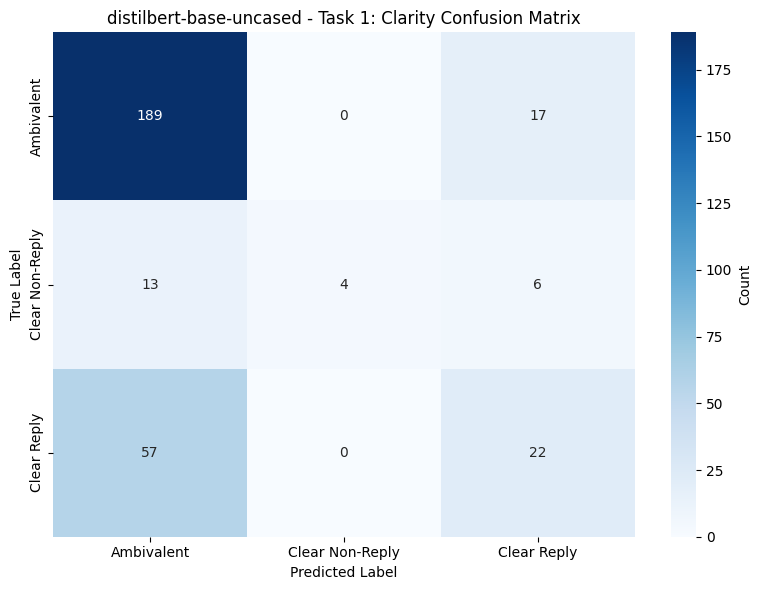

Summary (Task 1 | Test)
  - accuracy                      : 0.6981
  - macro_f1                      : 0.4880
  - weighted_f1                   : 0.6568

=> best_val_macro_f1: 0.5723

Config: LR=1e-05, WD=0.01


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



            MODEL = distilbert-base-uncased | TASK 1 = CLARITY (Single-task)            

Hyperparams: LR=1e-05, WD=0.01

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------


Epoch 1/5
------------------------------------------------------------
Train Loss: 0.9155
Val Accuracy: 0.5913
Val Macro F1: 0.2477

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.8557
Val Accuracy: 0.6087
Val Macro F1: 0.3837
Metric improved from 0.2477 to 0.3837

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.7797
Val Accuracy: 0.6319
Val Macro F1: 0.5277
Metric improved from 0.3837 to 0.5277

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.7147
Val Accuracy: 0.6493
Val Macro F1: 0.5708
Metric improved from 0.5277 to 0.5708

Epoch 5/5
-----------------

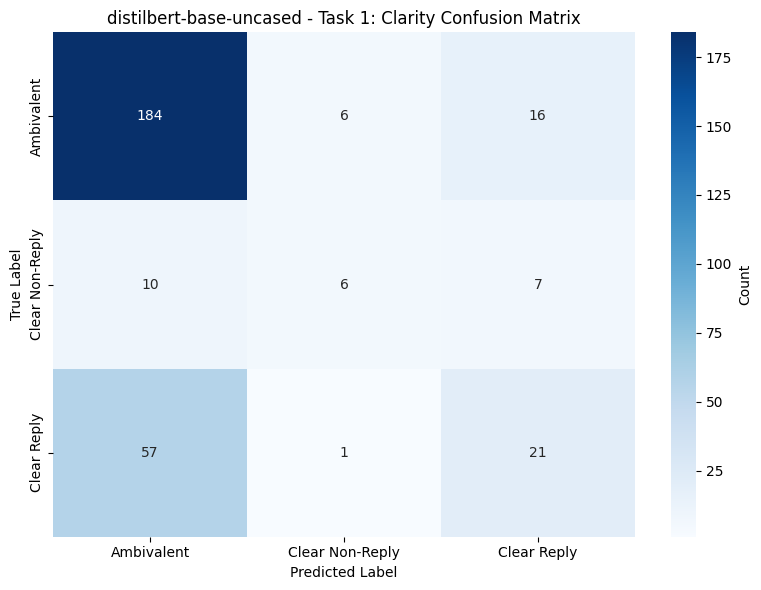

Summary (Task 1 | Test)
  - accuracy                      : 0.6851
  - macro_f1                      : 0.4933
  - weighted_f1                   : 0.6511

=> best_val_macro_f1: 0.5708

Config: LR=2e-05, WD=0.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



            MODEL = distilbert-base-uncased | TASK 1 = CLARITY (Single-task)            

Hyperparams: LR=2e-05, WD=0.0

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------


Epoch 1/5
------------------------------------------------------------
Train Loss: 0.9283
Val Accuracy: 0.6000
Val Macro F1: 0.2839

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.8283
Val Accuracy: 0.6319
Val Macro F1: 0.5537
Metric improved from 0.2839 to 0.5537

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.7066
Val Accuracy: 0.6696
Val Macro F1: 0.5888
Metric improved from 0.5537 to 0.5888

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.6120
Val Accuracy: 0.6261
Val Macro F1: 0.5687
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------

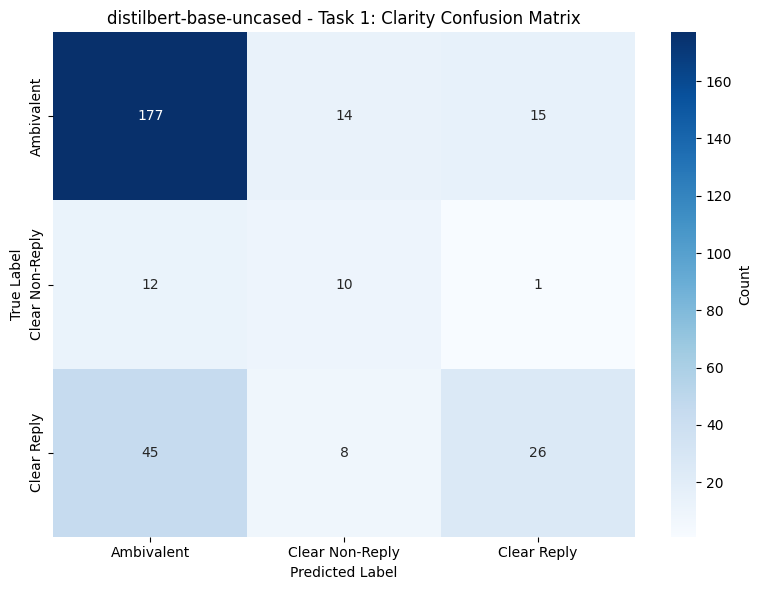

Summary (Task 1 | Test)
  - accuracy                      : 0.6916
  - macro_f1                      : 0.5326
  - weighted_f1                   : 0.6755

=> best_val_macro_f1: 0.5888

Config: LR=2e-05, WD=0.01


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



            MODEL = distilbert-base-uncased | TASK 1 = CLARITY (Single-task)            

Hyperparams: LR=2e-05, WD=0.01

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------


Epoch 1/5
------------------------------------------------------------
Train Loss: 0.9180
Val Accuracy: 0.5942
Val Macro F1: 0.2766

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.8410
Val Accuracy: 0.6406
Val Macro F1: 0.5313
Metric improved from 0.2766 to 0.5313

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.7246
Val Accuracy: 0.6116
Val Macro F1: 0.5418
Metric improved from 0.5313 to 0.5418

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.6153
Val Accuracy: 0.6493
Val Macro F1: 0.5663
Metric improved from 0.5418 to 0.5663

Epoch 5/5
-----------------

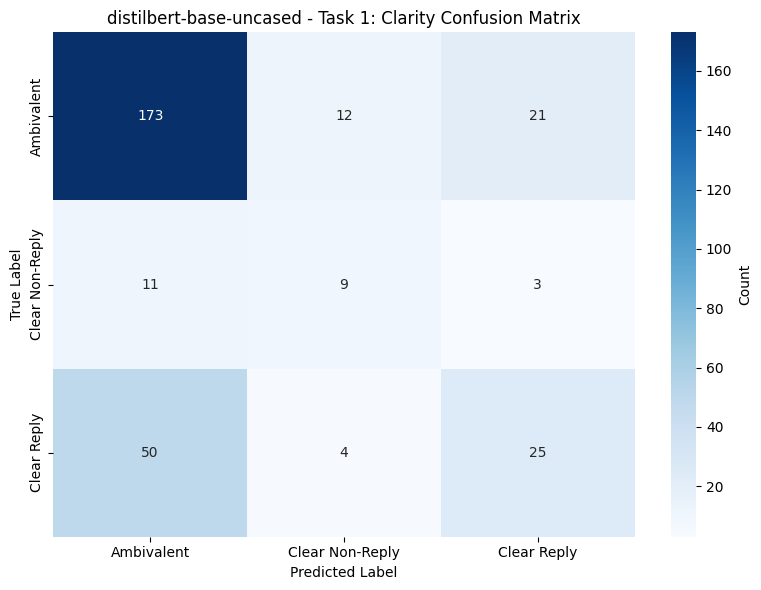

Summary (Task 1 | Test)
  - accuracy                      : 0.6721
  - macro_f1                      : 0.5173
  - weighted_f1                   : 0.6541

=> best_val_macro_f1: 0.5663

Config: LR=3e-05, WD=0.0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



            MODEL = distilbert-base-uncased | TASK 1 = CLARITY (Single-task)            

Hyperparams: LR=3e-05, WD=0.0

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------


Epoch 1/5
------------------------------------------------------------
Train Loss: 0.9071
Val Accuracy: 0.5942
Val Macro F1: 0.3144

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.8131
Val Accuracy: 0.6377
Val Macro F1: 0.5101
Metric improved from 0.3144 to 0.5101

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.6713
Val Accuracy: 0.6638
Val Macro F1: 0.5789
Metric improved from 0.5101 to 0.5789

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.5561
Val Accuracy: 0.6667
Val Macro F1: 0.6164
Metric improved from 0.5789 to 0.6164

Epoch 5/5
------------------

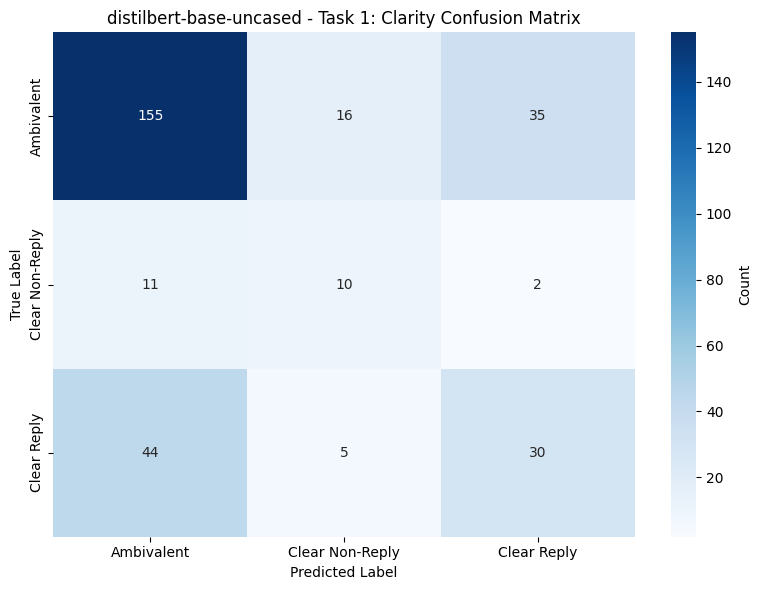

Summary (Task 1 | Test)
  - accuracy                      : 0.6331
  - macro_f1                      : 0.5088
  - weighted_f1                   : 0.6315

=> best_val_macro_f1: 0.6164

Config: LR=3e-05, WD=0.01


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



            MODEL = distilbert-base-uncased | TASK 1 = CLARITY (Single-task)            

Hyperparams: LR=3e-05, WD=0.01

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------


Epoch 1/5
------------------------------------------------------------
Train Loss: 0.9225
Val Accuracy: 0.5913
Val Macro F1: 0.2477

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.8076
Val Accuracy: 0.6464
Val Macro F1: 0.5896
Metric improved from 0.2477 to 0.5896

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.6876
Val Accuracy: 0.6522
Val Macro F1: 0.6004
Metric improved from 0.5896 to 0.6004

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.5684
Val Accuracy: 0.6319
Val Macro F1: 0.5746
No improvement for 1 epoch(s)

Epoch 5/5
-------------------------

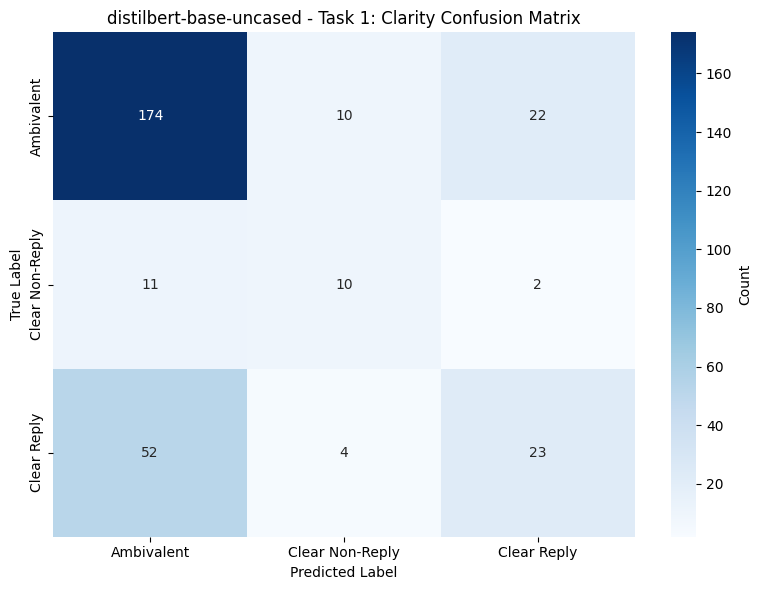

Summary (Task 1 | Test)
  - accuracy                      : 0.6721
  - macro_f1                      : 0.5254
  - weighted_f1                   : 0.6508

=> best_val_macro_f1: 0.6004

TUNING RESULTS


,lr,weight_decay,best_val_macro_f1
4,0.00003,0.00,0.616357
5,0.00003,0.01,0.600353
2,0.00002,0.00,0.588778
0,0.00001,0.00,0.572347
1,0.00001,0.01,0.570761
3,0.00002,0.01,0.566268


In [13]:
# ======================================
# HYPERPARAMETER TUNING on Task 1 ONLY
# ======================================

TUNING_MODEL = "distilbert-base-uncased"

LR_LIST = [1e-5, 2e-5, 3e-5]
WD_LIST = [0.0, 0.01]

tuning_rows = []

print("=== Tuning (Task 1 only) on:", TUNING_MODEL, "===")
print(f"Learning rates: {LR_LIST}")
print(f"Weight decays: {WD_LIST}")
print(f"Total configurations: {len(LR_LIST) * len(WD_LIST)}")

for lr in LR_LIST:
    for wd in WD_LIST:
        print("\n" + "="*50)
        print(f"Config: LR={lr}, WD={wd}")
        print("="*50)

        # Pass hyperparameters directly
        res = run_task1_only(TUNING_MODEL, lr=lr, wd=wd)
        score = res["best_val_macro_f1"]

        tuning_rows.append({
            "lr": lr,
            "weight_decay": wd,
            "best_val_macro_f1": score
        })

        print(f"=> best_val_macro_f1: {score:.4f}")

tuning_df = pd.DataFrame(tuning_rows).sort_values("best_val_macro_f1", ascending=False)
print("\n" + "="*50)
print("TUNING RESULTS")
print("="*50)
display(tuning_df)

In [14]:
# Select best configuration
best_config = tuning_df.iloc[0]
BEST_LR = float(best_config["lr"])
BEST_WD = float(best_config["weight_decay"])

print("\n=== Best Configuration ===")
print(f"Learning Rate: {BEST_LR}")
print(f"Weight Decay: {BEST_WD}")
print(f"Best Val Macro F1: {best_config['best_val_macro_f1']:.4f}")


=== Best Configuration ===
Learning Rate: 3e-05
Weight Decay: 0.0
Best Val Macro F1: 0.6164


## 7. Task 2: Evasion Classification

In [15]:
def run_task2_evasion(model_name: str, tokenizer, loaders: dict,
                      learning_rate: float = None,
                      weight_decay: float = None):
    """
    Run Task 2 (Evasion Classification) with optional hyperparameter override.
    """
    lr = learning_rate if learning_rate is not None else LEARNING_RATE
    wd = weight_decay if weight_decay is not None else WEIGHT_DECAY
    
    banner(f"MODEL = {model_name} | TASK 2 = EVASION (Single-task)")
    print(f"Hyperparams: LR={lr}, WD={wd}")

    section("Training (Train -> Val)")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(EVASION_LABELS),
        id2label=ID_TO_EVASION,
        label2id=EVASION_TO_ID
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = build_scheduler(optimizer, loaders["evasion_train"]) if USE_SCHEDULER else None
    loss_fn = FocalLoss(gamma=2.0)
    early_stopping = EarlyStopping(patience=PATIENCE, mode='max', verbose=True)

    history = train_model(
        model=model,
        train_loader=loaders["evasion_train"],
        val_loader=loaders["evasion_val"],
        optimizer=optimizer,
        scheduler=scheduler,
        clarity_loss_fn=loss_fn,
        evasion_loss_fn=loss_fn,
        device=device,
        num_epochs=NUM_EPOCHS,
        early_stopping=early_stopping,
        verbose=True,
        is_multitask=False
    )

    section("Validation evaluation (standard labels)")
    t2_val_metrics, t2_val_preds, t2_val_labels, _ = evaluate(
        model, loaders["evasion_val"], device, return_predictions=True
    )

    evaluate_task2_standard(
        y_true=t2_val_labels,
        y_pred=t2_val_preds,
        label_names=EVASION_LABELS,
        verbose=True
    )

    metric_block(
        "Summary (Task 2 | Val)",
        t2_val_metrics,
        keys=["accuracy", "macro_f1", "weighted_f1"]
    )

    section("Test evaluation (Multi-annotator: Accuracy@Any)")
    test_evasion_with_labels = evasion_test_df[
        evasion_test_df["annotator_labels"].apply(len) > 0
    ].reset_index(drop=True)

    test_evasion_dataset = QEvasionDataset(
        test_evasion_with_labels, tokenizer, MAX_LENGTH, task='evasion_test'
    )
    test_evasion_loader = DataLoader(test_evasion_dataset, batch_size=BATCH_SIZE)

    model.eval()
    test_pred_ids = []
    with torch.no_grad():
        for batch in test_evasion_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=-1)
            test_pred_ids.extend(preds.cpu().numpy())

    test_pred_labels = [ID_TO_EVASION[i] for i in test_pred_ids]
    gold_sets = test_evasion_with_labels["annotator_labels"].tolist()

    task2_test_metrics = evaluate_task2_multi_annotator(
        y_pred=test_pred_labels,
        gold_sets=gold_sets,
        verbose=True
    )

    # Hierarchy baseline: Evasion -> Clarity
    section("Hierarchy baseline: Evasion -> Clarity (on Clarity Test)")
    clarity_true_ids = clarity_test_df["clarity_id"].values

    model.eval()
    ev_preds_ids = []
    with torch.no_grad():
        for batch in loaders["clarity_test"]:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=-1)
            ev_preds_ids.extend(preds.cpu().numpy())

    ev_preds_ids = np.array(ev_preds_ids)
    implied_clarity_ids = map_evasion_ids_to_clarity_ids(ev_preds_ids)

    hier_metrics = evaluate_task1(
        y_true=clarity_true_ids,
        y_pred=implied_clarity_ids,
        label_names=CLARITY_LABELS,
        verbose=True
    )

    metric_block(
        "Summary (Hierarchy baseline | Evasion->Clarity on Task1 test)",
        hier_metrics,
        keys=["accuracy", "macro_f1", "weighted_f1"]
    )

    summary = {
        "Task2_Val_Acc": t2_val_metrics["accuracy"],
        "Task2_Val_MacroF1": t2_val_metrics["macro_f1"],
        "Task2_Val_WeightedF1": t2_val_metrics["weighted_f1"],
        "Task2_Test_Acc_AnyAnnotator": task2_test_metrics["accuracy_any_annotator"],
        "Hierarchy_Clarity_MacroF1": hier_metrics["macro_f1"],
    }

    return model, optimizer, history, summary

## 8. Final Runs with Best Configuration

In [16]:
def run_full_pipeline(model_name: str, lr: float = None, wd: float = None):
    """
    Run both Task 1 and Task 2 for a given model with specified hyperparameters.
    """
    banner(f"FULL PIPELINE: {model_name}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    loaders = build_dataloaders(tokenizer)
    
    # Task 1
    t1_model, t1_opt, t1_hist, t1_sum = run_task1_clarity(
        model_name, loaders, learning_rate=lr, weight_decay=wd
    )
    cleanup(t1_model, t1_opt)
    
    # Task 2
    t2_model, t2_opt, t2_hist, t2_sum = run_task2_evasion(
        model_name, tokenizer, loaders, learning_rate=lr, weight_decay=wd
    )
    cleanup(t2_model, t2_opt)
    
    # Combine results
    summary = {"Model": model_name, "LR": lr, "WD": wd}
    summary.update(t1_sum)
    summary.update(t2_sum)
    
    section("Final Summary")
    metric_block("Key Metrics", summary, [
        "Task1_Test_MacroF1",
        "Task2_Val_MacroF1",
        "Task2_Test_Acc_AnyAnnotator",
        "Hierarchy_Clarity_MacroF1"
    ])
    
    return summary


=== FINAL RUN: DistilBERT (with best config) ===

                         FULL PIPELINE: distilbert-base-uncased                         



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



            MODEL = distilbert-base-uncased | TASK 1 = CLARITY (Single-task)            

Hyperparams: LR=3e-05, WD=0.0

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------


Epoch 1/5
------------------------------------------------------------
Train Loss: 0.9054
Val Accuracy: 0.6174
Val Macro F1: 0.4830

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.7783
Val Accuracy: 0.6406
Val Macro F1: 0.5359
Metric improved from 0.4830 to 0.5359

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.6603
Val Accuracy: 0.6638
Val Macro F1: 0.5817
Metric improved from 0.5359 to 0.5817

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.5703
Val Accuracy: 0.6435
Val Macro F1: 0.5800
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------

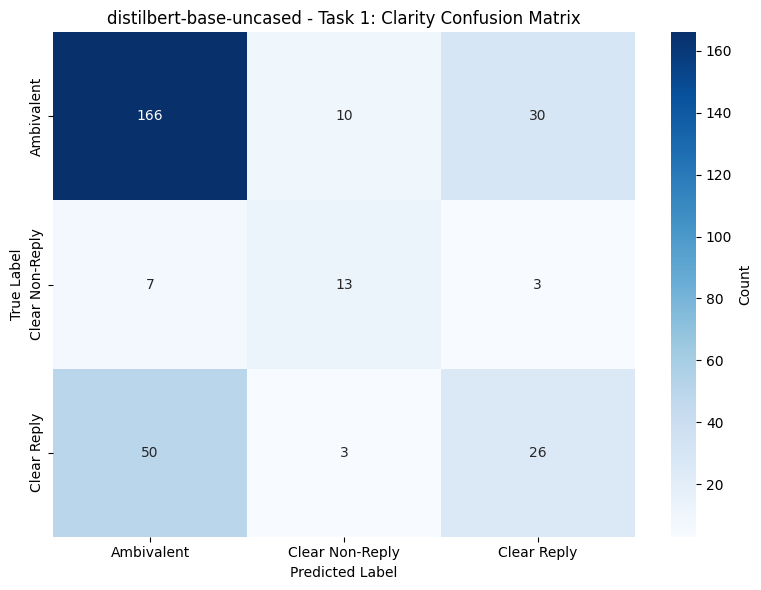

Summary (Task 1 | Test)
  - accuracy                      : 0.6656
  - macro_f1                      : 0.5604
  - weighted_f1                   : 0.6539



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



            MODEL = distilbert-base-uncased | TASK 2 = EVASION (Single-task)            

Hyperparams: LR=3e-05, WD=0.0

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------


Epoch 1/5
------------------------------------------------------------
Train Loss: 1.9448
Val Accuracy: 0.3014
Val Macro F1: 0.0552

Epoch 2/5
------------------------------------------------------------
Train Loss: 1.7670
Val Accuracy: 0.3594
Val Macro F1: 0.1747
Metric improved from 0.0552 to 0.1747

Epoch 3/5
------------------------------------------------------------
Train Loss: 1.6303
Val Accuracy: 0.3855
Val Macro F1: 0.2234
Metric improved from 0.1747 to 0.2234

Epoch 4/5
------------------------------------------------------------
Train Loss: 1.4740
Val Accuracy: 0.3826
Val Macro F1: 0.3086
Metric improved from 0.2234 to 0.3086

Epoch 5/5
------------------

In [17]:
# Run with best configuration from tuning
print("\n=== FINAL RUN: DistilBERT (with best config) ===")
res_distilbert = run_full_pipeline("distilbert-base-uncased", lr=BEST_LR, wd=BEST_WD)


=== FINAL RUN: BERT (with best config) ===

                            FULL PIPELINE: bert-base-uncased                            



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


               MODEL = bert-base-uncased | TASK 1 = CLARITY (Single-task)               

Hyperparams: LR=3e-05, WD=0.0

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
------------------------------------------------------------
Train Loss: 0.9111
Val Accuracy: 0.6116
Val Macro F1: 0.3700

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.7814
Val Accuracy: 0.6406
Val Macro F1: 0.5270
Metric improved from 0.3700 to 0.5270

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.6526
Val Accuracy: 0.6493
Val Macro F1: 0.6066
Metric improved from 0.5270 to 0.6066

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.5245
Val Accuracy: 0.6638
Val Macro F1: 0.6285
Metric improved from 0.6066 to 0.6285

Epoch 5/5
------------------------------------------------------------
Train Loss: 0.4203
Val Accuracy: 0.6667
Val Macro F1: 0.6379
Metric improved from 0.6285 to 0.6379

----------------------------------------------------------------------------------------
Test evaluation
-----------------------------------------------------------------------------

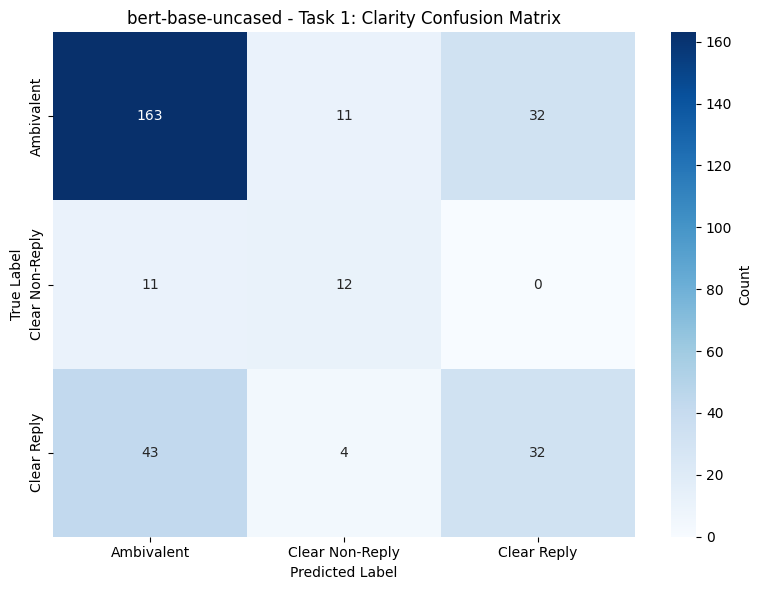

Summary (Task 1 | Test)
  - accuracy                      : 0.6721
  - macro_f1                      : 0.5661
  - weighted_f1                   : 0.6661



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



               MODEL = bert-base-uncased | TASK 2 = EVASION (Single-task)               

Hyperparams: LR=3e-05, WD=0.0

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------


Epoch 1/5
------------------------------------------------------------
Train Loss: 1.9213
Val Accuracy: 0.3101
Val Macro F1: 0.1245

Epoch 2/5
------------------------------------------------------------
Train Loss: 1.7134
Val Accuracy: 0.3217
Val Macro F1: 0.1945
Metric improved from 0.1245 to 0.1945

Epoch 3/5
------------------------------------------------------------
Train Loss: 1.5256
Val Accuracy: 0.3797
Val Macro F1: 0.3021
Metric improved from 0.1945 to 0.3021

Epoch 4/5
------------------------------------------------------------
Train Loss: 1.3480
Val Accuracy: 0.3623
Val Macro F1: 0.2887
No improvement for 1 epoch(s)

Epoch 5/5
--------------------------

In [18]:
print("\n=== FINAL RUN: BERT (with best config) ===")
res_bert = run_full_pipeline("bert-base-uncased", lr=BEST_LR, wd=BEST_WD)


=== FINAL RUN: ALBERT (with best config) ===

                             FULL PIPELINE: albert-base-v2                              



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]


                MODEL = albert-base-v2 | TASK 1 = CLARITY (Single-task)                 

Hyperparams: LR=3e-05, WD=0.0

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------



model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
------------------------------------------------------------
Train Loss: 0.9103
Val Accuracy: 0.6000
Val Macro F1: 0.3350

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.8439
Val Accuracy: 0.6493
Val Macro F1: 0.5181
Metric improved from 0.3350 to 0.5181

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.7403
Val Accuracy: 0.6464
Val Macro F1: 0.5041
No improvement for 1 epoch(s)

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.6152
Val Accuracy: 0.6435
Val Macro F1: 0.5488
Metric improved from 0.5181 to 0.5488

Epoch 5/5
------------------------------------------------------------
Train Loss: 0.4868
Val Accuracy: 0.6348
Val Macro F1: 0.5812
Metric improved from 0.5488 to 0.5812

----------------------------------------------------------------------------------------
Test evaluation
-------------------------------------------------------------------------------------

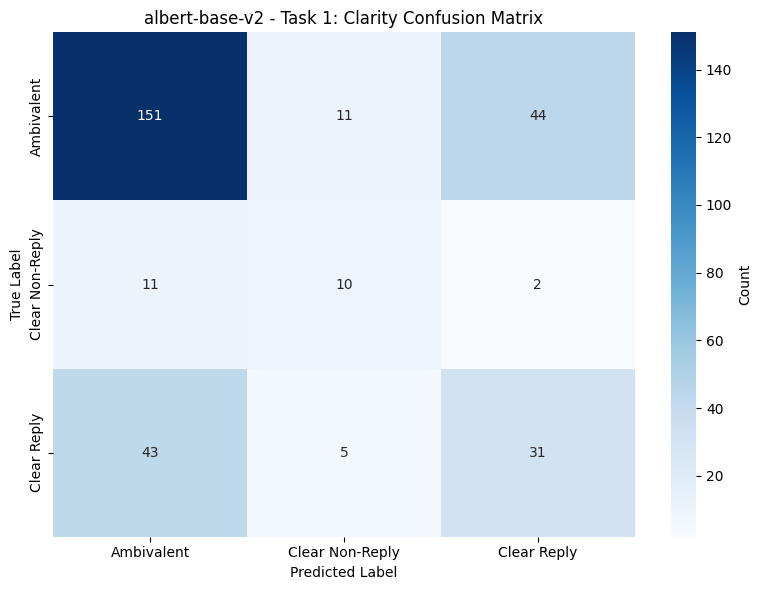

Summary (Task 1 | Test)
  - accuracy                      : 0.6234
  - macro_f1                      : 0.5135
  - weighted_f1                   : 0.6239


                MODEL = albert-base-v2 | TASK 2 = EVASION (Single-task)                 

Hyperparams: LR=3e-05, WD=0.0

----------------------------------------------------------------------------------------
Training (Train -> Val)
----------------------------------------------------------------------------------------



Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
------------------------------------------------------------
Train Loss: 1.9034
Val Accuracy: 0.3362
Val Macro F1: 0.0872

Epoch 2/5
------------------------------------------------------------
Train Loss: 1.7640
Val Accuracy: 0.3014
Val Macro F1: 0.1848
Metric improved from 0.0872 to 0.1848

Epoch 3/5
------------------------------------------------------------
Train Loss: 1.6284
Val Accuracy: 0.3420
Val Macro F1: 0.2250
Metric improved from 0.1848 to 0.2250

Epoch 4/5
------------------------------------------------------------
Train Loss: 1.4754
Val Accuracy: 0.3739
Val Macro F1: 0.2756
Metric improved from 0.2250 to 0.2756

Epoch 5/5
------------------------------------------------------------
Train Loss: 1.2874
Val Accuracy: 0.3565
Val Macro F1: 0.2981
Metric improved from 0.2756 to 0.2981

----------------------------------------------------------------------------------------
Validation evaluation (standard labels)
-----------------------------------------------------

In [19]:
print("\n=== FINAL RUN: ALBERT (with best config) ===")
res_albert = run_full_pipeline("albert-base-v2", lr=BEST_LR, wd=BEST_WD)

In [20]:
# Collect and display all results
all_results = [res_distilbert, res_bert, res_albert]
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("FINAL COMPARISON")
print("="*80)
display(results_df)

# Save results
results_df.to_csv("qevasion_final_comparison.csv", index=False)
print("\nSaved: qevasion_final_comparison.csv")


FINAL COMPARISON


,Model,LR,WD,Task1_Test_Acc,Task1_Test_MacroF1,Task1_Test_WeightedF1,best_val_macro_f1,Task2_Val_Acc,Task2_Val_MacroF1,Task2_Val_WeightedF1,Task2_Test_Acc_AnyAnnotator,Hierarchy_Clarity_MacroF1
0,distilbert-base-uncased,0.00003,0.0,0.665584,0.560439,0.653877,0.582283,0.394203,0.337743,0.352891,0.415584,0.450211
1,bert-base-uncased,0.00003,0.0,0.672078,0.566079,0.666097,0.637858,0.373913,0.326274,0.344565,0.422078,0.446031
2,albert-base-v2,0.00003,0.0,0.623377,0.513464,0.623872,0.581222,0.356522,0.298125,0.322888,0.444805,0.488634



Saved: qevasion_final_comparison.csv
